In [120]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import csv
from cartopy.io import shapereader 

ModuleNotFoundError: No module named 'cartopy'

# Particle size distribution analysis 
Steven Cunningham 5/20/2017

# Introduction
   Hydrodynamic forces within and around kelp beds are influenced by the presence of giant kelp (Macrocystis pyrifera) (Jackson 1983, Graham 2003, Gaylord et al. 2007, Rosman et al. 2007). Drag by Macrocystis through the water column results in only 20-70% of flow from prevailing currents extending into the center of a kelp forest (Gaylord et al. 2007); kelp beds have been shown to reduce the current velocity by nearly a factor of 4 (Jackson 1997, Gaylord et al. 2007, Rosman et al. 2007). Kelp beds, therefore, act similarly to airplane wings, causing flow to increase around the periphery by 200% (Gaylord et al. 2007). The biological implications for such water flow retardation rests on the particulates’ ability to sink, rather than drift, through the water column, which is critical for the feeding of suspension feeders and successful recruitment for a variety of organisms that rely on spore settlement, including Macrocystis itself (Gaylord et al. 2002, Graham 2003). A decrease in turbulent mixing is expected to lead to smaller within-bed fluxes of neutrally buoyant particles like phytoplankton and other POM (Denny & Shibata 1989, Rosman et al. 2010). Nevertheless, few studies have attempted to understand flow dynamics through kelp beds on smaller spatial scales, and the effect of kelp stipe density on flow or transport of particles. 
    How fluids flow around a cylinder are well known (Meneghini & Saltra 2001, Norberg 2001, Lam et al. 2003). At a certain flow velocity and cylinder diameter, turbulent shedding is created on the down-flow side of the cylinder (reviewed by Denny 1988). Preliminary flume experiments on a 1:45 scale kelp forest show that the M. pyrifera thallus is capable of diverting flow vertically from the benthos. I hypothesize that this turbulent shedding occurs around the stipe bundle of M. pyrifera causing vertical transport of benthic particulates. Understanding this transport mechanism will help explain how the giant kelp supplies and influences POC distribution within kelp forests. I propose to construct artificial kelp to test if particles can be mixed through the water column compared to areas of no kelp. Artificial kelp will be used to reduce the amount of particles produced by sloughing.
    

# Methods
    The study area will be at Stillwater Cove (SWC)(Fig. 1), California. Three sites will be set within three kelp beds. Within each site, two 10m diameter plots will be cleared of kelp and one plot will be seeded with artificial kelp. From a small research vessel water will be pumped through an intake hose passing through a course filter (2mm pore size). The pump will be equipped with 4 intake vinyl hoses that reach 4 zones of the water column at depths of 0m, 2.5m, 5m, and 7.5m. 2L of water will be pumped from each zone and expelled into opaque plastic bottles for each zone for particle analysis. Each site will be sampled once a week for 3 months. 
     Once at the lab, 50ml of the original sample will be used for particle analysis. This subsample will be placed into a 50ml falcon tube and will be centrifuged at 1.5 x 1000 rev/minute for 20 min, as described in USGS Laboratory Analysis (1987). After the sample has been centrifuged, 45ml of the supernatant will be removed by aspiration and 0.5ml of glutaraldehyde is added as a fixing agent yielding a final concentration of 1:9.09. Particulates will be quantified by Sedgewick Rafter slide and a light microscope at 100x magnification. 20 random fields of view will be imaged, then using ImageJ particle analysis script, particle count and area will be recorded. Using python, I will create a function that will take the sample particle area and plot as a histogram. To characterize this dataset, I will run a regression on the histogram and plot the regression line on the same plot. The slope of this line will be the characteristic to compare against other histograms. For this analysis, only one depth zone (2.3 m)will be analized across treatments. This is due to the fact that not all data has been processed yet and the 2.5 m zone would likely be the least detectable difference. As flow is pushing particles upward, larger particales would not likely been seen closer to the surface as they would fall back when flow relaxes.  


In [ ]:
#Figure 1: Study site stillwater cove (SWC), CA
SWCshp = shapereader.Reader('SWC/CUSPLine.shp') # pull shape file from folder SWC directory. Data pulled from NOAA
request = cimgt.GoogleTiles(style="satellite")
plt.figure()
p=ccrs.PlateCarree()
ax=plt.axes(projection=ccrs.Orthographic(-121.93,36.54))
extent=(-121.934,-121.954,36.556,36.569)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.35)
gl.xlabels_top = False
gl.ylabels_left = False

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

for geometry in SWCshp.geometries():
    ax.add_geometries(geometry,p,facecolor ='lightgray', edgecolors='black')#facecolor='white'
ax.set_extent(extent)

Using the Code below I will test my alternative hypothesis:

# HA: There is a difference in vertical particle load in the presence or absence of M. pyrifera stipes. 

After ImageJ script has been ran on all directories begin using python code below


In [ ]:
#Define your path to directory with raw particle data
path = "302T/" 

In [109]:
# for loop that combines all .xls files within path directory. Creates new variable "all_data" as .csv 
# and saves within path directory as "total_particles"
all_data = pd.DataFrame()
for f in glob.glob(path+'\*.xls'): #you may need to change \ -> / if on mac
    df = pd.read_csv(f,sep='\s+') #you may need to change \ -> / if on mac
    all_data = all_data.append(df,ignore_index=True) 
    
all_data.to_csv(path+'/total_particles.csv')

In [110]:
# Read new total_particle.csv and define variable "area" 
file= path+'/total_particles.csv'
df = pd.read_csv(file,header=0)
area=df['Area']

# transform surface area to equivalent spherical diameter (ESD)
ESD = (2*(area/np.pi)**.5) 

In [111]:
# define bins (how many, width, and center). Code in this cell modified from Colleen Durkin. 

bins = []
for x in np.arange(1.5,10,.5):
    bin = 2**x
    bins.append(bin)

bin_mids = []
for y in np.arange(0,len(bins)-1):
    mid = bins[y] + (bins[y+1]-bins[y])/2
    bin_mids.append(mid)

bin_width = []
for z in np.arange(0,len(bins)-1):
    width = (bins[z+1]-bins[z])
    bin_width.append(width)

In [112]:
# Use numpy histgram to sort particle counts into size class bins. This sorted data is then normalized by bin width. 

histogram=np.histogram(ESD,bins=bins,range=None, normed=False, weights=None, density=None) 
n=(histogram[0]/bin_width)*10 #normalized added *10 so no negatives after log transform this will be corrected when count/ml

In [113]:
# get rid of bins with no data

bin_mids_array=np.asarray(bin_mids) # change bin_mids from tuple to array so can be indexed
ii=np.where(n>0) # index to remove zero data
bin_mids_nonzero=bin_mids_array[ii] # only bins with data
n_nozero=n[ii] # no zero values

In [114]:
# PSD function will be used in max.min to calculate differences in estimated power equation from real data

def PSD (var, bin_mid, normalized): #var is in format of [#,#], normilized = my n
    normalized_n = normalized#[normalized>0]
    bin_center = bin_mids_nonzero # figure this line out
    Y = (10**var[0])*bin_mids_nonzero**var[1]
    difference = np.sum((np.log(Y)- np.log(n_nozero))**2)
    return difference 

In [115]:
# optimize the power equation fit using PSD function. Output is variables A and B in equation y = A(x)^B

maxmin=scipy.optimize.minimize(PSD, [1, -3], args= (bin_mids, n)) # then use these to plot y= over hist with estimates of [1,-3]


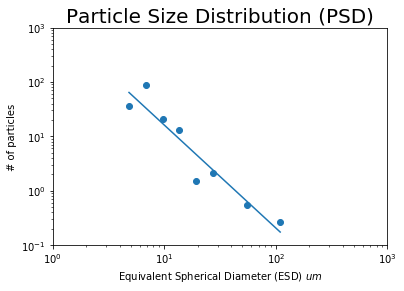

In [116]:
# Figure 2 log-log plot of particle counts vs equivalent spherical diameter (um)
plt.figure()
plt.scatter(bin_mids_nonzero, n_nozero)
plt.plot(bin_mids_nonzero,(10**maxmin['x'][0])*bin_mids_nonzero**(maxmin['x'][1])) #this is where you add in variable x from optimize.min result 
plt.xlabel('Equivalent Spherical Diameter (ESD) $um$', fontsize=10 )
plt.ylabel('# of particles', fontsize=10)
plt.title('Particle Size Distribution (PSD)', fontsize=20)
#plt.text(300,40, 'n='+total_count,verticalalignment='bottom', horizontalalignment='left',color='black', fontsize=10)
plt.yscale('log')
plt.xscale('log')
plt.axis([1,1000,.1,1000])
plt.savefig(path+'plot')
plt.show()

In [117]:
# add slope and intercept for power eqution to main data file 
df.head()
df['Intercept'] = maxmin['x'][0]
df['slope'] = maxmin['x'][1]
df.to_csv(path+'/total_particles.csv')

Now all slopes of PSD are calculated and saved as file (total_particles) within the corresponding directory. Now pull all slopes from files and combine for each treatment. 

In [ ]:
#locate all total particle files for treatment 1 (Artificial)
file1 = "254A/total_particles.csv" 
file2 = "254AA/total_particles.csv"
file3 = "306A/total_particles.csv"
dfa1 = pd.read_csv(file1,header=0)
dfa2 = pd.read_csv(file2,header=0)
dfa3 = pd.read_csv(file3,header=0)
slope_artificial1=dfa1['slope'][1]
slope_artificial2=dfa2['slope'][1]
slope_artificial3=dfa3['slope'][1]
Artificial=[slope_artificial1,slope_artificial2,slope_artificial3]

In [ ]:
#locate all total particle files for treatment 2 (Control)
filec1 = "318C/total_particles.csv"
filec2 = "294C/total_particles.csv"
filec3 = "296C/total_particles.csv"
dfc1 = pd.read_csv(filec1,header=0)
dfc2 = pd.read_csv(filec2,header=0)
dfc3 = pd.read_csv(filec2,header=0)
slope_control1=dfc1['slope'][1]
slope_control2=dfc2['slope'][1]
slope_control3=dfc3['slope'][1]
Kelp=[slope_control1,slope_control2,slope_control3]

In [ ]:
#locate all total particle files for treatment 3 (Clearings)
filet1 = "298T/total_particles.csv"
filet2 = "302T/total_particles.csv"
filet3 = "322T/total_particles.csv"
dft1 = pd.read_csv(filet1,header=0)
dft2 = pd.read_csv(filet2,header=0)
dft3 = pd.read_csv(filet3,header=0)
slope_clear1=dft1['slope'][1]
slope_clear2=dft2['slope'][1]
slope_clear3=dft3['slope'][1]
Clearing=[slope_clear1,slope_clear2,slope_clear3]

In [ ]:
# run a one-way ANOVA 
scipy.stats.f_oneway(Clearing,Kelp,Artificial) #gives the F-stat and P-value 

# Results

	All particle size densities (PSD) were plotted on log-log plot for each treatment at depth 2.5 m (Fig. 2). Once all PSD slopes were obtained the following code pulled slopes from generated tables in each directory. A one way analysis of variance (ANOVA) showed no difference in PSD between treatments (F = 1.94, p = 0.22). There is no need to run any post hoc tests as the results were not significant. 


# Discussion 

	There was no difference in PSD at depth zone (2.5 m) between plots. However, this analysis needs to be carried out for all depths. It is possible that vertical transport of particles occurs, but not that far. Testing depth zone (5 m) samples possibly might have a greater difference in PSD than 2.5 m. Other factors that need to be accounted for in the model are water motion on the days that the samples were taken. If the fluid velocity is what moves the particles vertically, then on calm days there would be no re-suspension of particles.  These factors would be current velocity, wave energy, and wave orbital size. 
